In [1]:

"""
Auto correlation Test

Autocorrelation, at its core, measures the linear relationship between a time series and a lagged version of itself.
In simpler terms, it tells you how similar a sequence of data is to a copy of itself shifted by a certain number of positions (the lag).


If the value at lag10 is close to 1, it means that if you see a specific card at a given position, there's a high probability that you'll see a
similar card 10 positions later.

"""

'Linear Complexity Test\nhow predictable the sequence is based on linear relationships among its elements.\n\n'

In [ ]:
"""
1. Small Lags (Crucial for Immediate Dependencies)
Lags 1-10
sensitive to short-term biases

2. Medium Lags (To Catch Mid-Range Patterns)
Lags 25, 50, 75, 100, 150, 200

3. Logarithmically Spaced Lags (For a Broader View)
Lags 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024
Reasoning: Logarithmic spacing is useful for exploring patterns across various scales and is often used when the data is large.

4. Some Larger Lags (With Caution)
Lags 1000, 2000, 5000, 10000

5. Specific Lags Related to Deck Size (Optional, but potentially insightful)
Lags 52, 104, 156, 208
"""

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import acf

In [44]:
data=r"/Users/macbookpro/Documents/RNG_testing/df_Small.csv"
df=pd.read_csv(data)
df=df.iloc[:1000]

## Dice

In [45]:
df_Dice= df[["dice"]]

In [46]:
#Seprating columns
df_Dice.loc[:,'Die1'] = df_Dice['dice'].apply(lambda x: x[0])
df_Dice.loc[:,'Die2'] = df_Dice['dice'].apply(lambda x: x[2])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [72]:
#one long sequence 

Die1_lst= df_Dice["Die1"].astype(int).values
#for the 100million: 
"""lags_to_test = list(range(1, 21)) + [25, 50, 75, 100, 150, 200] + \
              [2**i for i in range(1, 11)] + [1000, 2000, 5000, 10000] + \
              [6, 36,216]"""

lags_to_test= [1,2,3,4,5,6,7,8,9,10,
                25,50,75,100,150,200,
                2,4,8,16,32,64,128,
                ]

max_lag = max(lags_to_test)


# Calculate autocorrelation for the entire sequence
autocorr = acf(Die1_lst, nlags=max_lag, fft=True , alpha=0.01)

# Extract autocorrelation values and confidence intervals
autocorr_values = autocorr[0]
confidence_intervals = autocorr[1]

# Calculate the confidence interval bounds
lower_bounds = confidence_intervals[:, 0] - autocorr_values
upper_bounds = confidence_intervals[:, 1] - autocorr_values

In [73]:
# Create a DataFrame to store the results
results_dice = pd.DataFrame({
    'lag': lags_to_test,
    'autocorrelation': autocorr_values[lags_to_test],
    'lower_bound': lower_bounds[lags_to_test],
    'upper_bound': upper_bounds[lags_to_test]
})

# Determine statistical significance
results_dice['significant'] = (results_dice['autocorrelation'] < results_dice['lower_bound']) | (results_dice['autocorrelation'] > results_dice['upper_bound'])


#Autocorrelation values that fall outside the confidence interval suggest a non-random pattern in the shuffling process.
results_dice

,lag,autocorrelation,lower_bound,upper_bound,significant
0,1,0.023489,-0.081455,0.081455,False
1,2,0.031346,-0.081500,0.081500,False
2,3,0.047598,-0.081580,0.081580,False
3,4,0.030699,-0.081764,0.081764,False
4,5,-0.056175,-0.081840,0.081840,False
5,6,0.010733,-0.082096,0.082096,False
6,7,-0.038268,-0.082105,0.082105,False
7,8,-0.001935,-0.082223,0.082223,False
8,9,0.016798,-0.082224,0.082224,False
9,10,-0.027194,-0.082246,0.082246,False


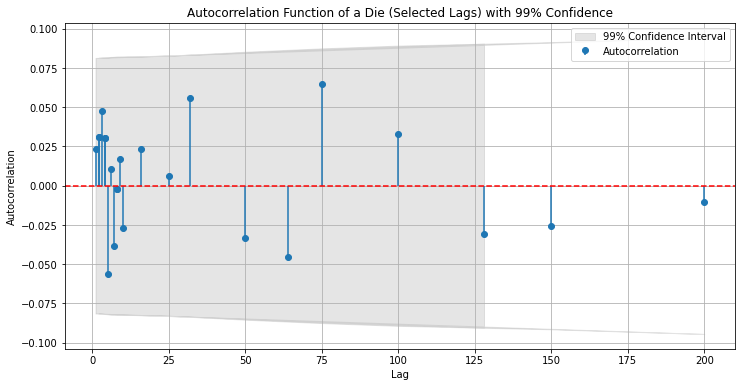

In [76]:
plt.figure(figsize=(12, 6))
plt.stem(results_dice['lag'], results_dice['autocorrelation'], markerfmt='o', basefmt=' ', label='Autocorrelation')
plt.fill_between(results_dice['lag'], results_dice['lower_bound'], results_dice['upper_bound'], color='gray', alpha=0.2, label='99% Confidence Interval')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of a Die (Selected Lags) with 99% Confidence')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.legend()
plt.show()

## Cards 

In [53]:
df_card=df[["card"]]

In [54]:
#seperating cards
cards_column= df_card["card"].str.split("," , expand=True)
#Rename columns
cards_column.columns= [f"{i+1}" for i in range(cards_column.shape[1])]

In [55]:
def create_card_mapping():
    #Creates a mapping from card string to a number (1-52)

    ranks = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']
    suits = ['H', 'D', 'C', 'S']
    cards = [rank + suit for suit in suits for rank in ranks]
    return {card: i + 1 for i, card in enumerate(cards)}


#Mapping cards to 1-52
numeric_df= cards_column.apply(lambda x: [create_card_mapping()[card] for card in x])

In [68]:

#for the 100million: 
"""lags_to_test = list(range(1, 21)) + [25, 50, 75, 100, 150, 200] + \
              [2**i for i in range(1, 11)] + [1000, 2000, 5000, 10000] + \
              [52, 104, 156, 208]"""

lags_to_test= [1,2,3,4,5,6,7,8,9,10,
                25,50,75,100,150,200,
                2,4,8,16,32,64,128,
                52,104,156,208]

max_lag = max(lags_to_test)

# Flatten the data into a single sequence, cause autocorrelation needs a single time series.
card_data = numeric_df.values.flatten()

# Calculate autocorrelation for the entire sequence
autocorr = acf(card_data, nlags=max_lag, fft=True , alpha=0.01)

# Extract autocorrelation values and confidence intervals
autocorr_values = autocorr[0]
confidence_intervals = autocorr[1]

# Calculate the confidence interval bounds
lower_bounds = confidence_intervals[:, 0] - autocorr_values
upper_bounds = confidence_intervals[:, 1] - autocorr_values


In [69]:
# Create a DataFrame to store the results
results_card = pd.DataFrame({
    'lag': lags_to_test,
    'autocorrelation': autocorr_values[lags_to_test],
    'lower_bound': lower_bounds[lags_to_test],
    'upper_bound': upper_bounds[lags_to_test]
})

# Determine statistical significance
results_card['significant'] = (results_card['autocorrelation'] < results_card['lower_bound']) | (results_card['autocorrelation'] > results_card['upper_bound'])

#statistically significant(falls outside the confidence interval), it suggests that the sequence is not random.
results_card

,lag,autocorrelation,lower_bound,upper_bound,significant
0,1,-0.016328,-0.011296,0.011296,True
1,2,-0.011702,-0.011299,0.011299,True
2,3,-0.015668,-0.011300,0.011300,True
3,4,-0.024151,-0.011303,0.011303,True
4,5,-0.018357,-0.011310,0.011310,True
5,6,-0.016616,-0.011313,0.011313,True
6,7,-0.016565,-0.011317,0.011317,True
7,8,-0.014932,-0.011320,0.011320,True
8,9,-0.026137,-0.011322,0.011322,True
9,10,-0.021811,-0.011330,0.011330,True


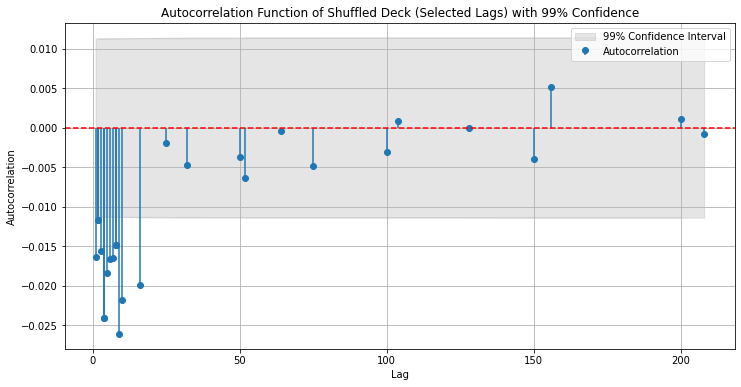

In [71]:
plt.figure(figsize=(12, 6))
plt.stem(results_card['lag'], results_card['autocorrelation'], markerfmt='o', basefmt=' ', label='Autocorrelation')
plt.fill_between(results_card['lag'], results_card['lower_bound'], results_card['upper_bound'], color='gray', alpha=0.2, label='99% Confidence Interval')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of Shuffled Deck (Selected Lags) with 99% Confidence')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.legend()
plt.show()

## Lotto

In [61]:
df_lotto=df[["lotoo"]]

In [62]:
#seprating values
df_lotto= df_lotto["lotoo"].str.split("," , expand=True)

In [63]:
df_lotto.astype(int).values.flatten()

array([ 2, 40, 33, ..., 57, 31, 36])

In [64]:
#for the 100million: 
"""lags_to_test = list(range(1, 21)) + [25, 50, 75, 100, 150, 200] + \
              [2**i for i in range(1, 11)] + [1000, 2000, 5000, 10000] + \
              [52, 104, 156, 208]"""

lags_to_test= [1,2,3,4,5,6,7,8,9,10,
                25,50,75,100,150,200,
                2,4,8,16,32,64,128,
                52,104,156,208]

max_lag = max(lags_to_test)

# Flatten the data into a single sequence, cause autocorrelation needs a single time series.
data = df_lotto.astype(int).values.flatten()

# Calculate autocorrelation for the entire sequence
autocorr = acf(data, nlags=max_lag, fft=True , alpha=0.01)

# Extract autocorrelation values and confidence intervals
autocorr_values = autocorr[0]
confidence_intervals = autocorr[1]

# Calculate the confidence interval bounds
lower_bounds = confidence_intervals[:, 0] - autocorr_values
upper_bounds = confidence_intervals[:, 1] - autocorr_values

In [65]:
# Create a DataFrame to store the results
results_lotto = pd.DataFrame({
    'lag': lags_to_test,
    'autocorrelation': autocorr_values[lags_to_test],
    'lower_bound': lower_bounds[lags_to_test],
    'upper_bound': upper_bounds[lags_to_test]
})

# Determine statistical significance
results_lotto['significant'] = (results_lotto['autocorrelation'] < results_lotto['lower_bound']) | (results_lotto['autocorrelation'] > results_lotto['upper_bound'])

#statistically significant(falls outside the confidence interval), it suggests that the sequence is not random.
results_lotto

,lag,autocorrelation,lower_bound,upper_bound,significant
0,1,-0.020506,-0.033254,0.033254,False
1,2,-0.020932,-0.033268,0.033268,False
2,3,-0.018279,-0.033282,0.033282,False
3,4,0.003410,-0.033293,0.033293,False
4,5,-0.005452,-0.033294,0.033294,False
5,6,0.012670,-0.033295,0.033295,False
6,7,0.004102,-0.033300,0.033300,False
7,8,0.013219,-0.033301,0.033301,False
8,9,-0.024067,-0.033307,0.033307,False
9,10,0.001972,-0.033326,0.033326,False


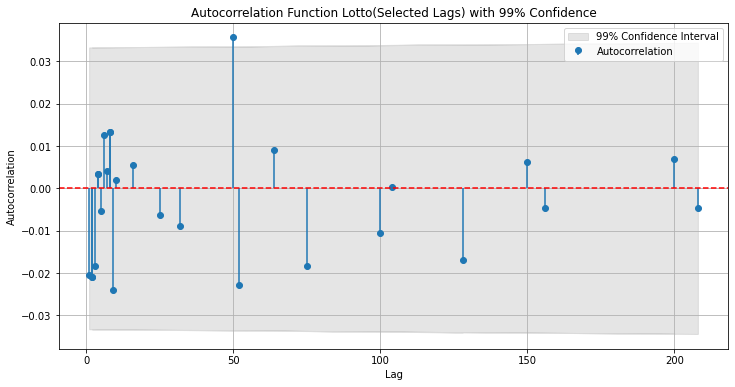

In [67]:
plt.figure(figsize=(12, 6))
plt.stem(results_lotto['lag'], results_lotto['autocorrelation'], markerfmt='o', basefmt=' ', label='Autocorrelation')
plt.fill_between(results_lotto['lag'], results_lotto['lower_bound'], results_lotto['upper_bound'], color='gray', alpha=0.2, label='99% Confidence Interval')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function Lotto(Selected Lags) with 99% Confidence')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.legend()
plt.show()